# Security Example with CARLA Visualization - BSM Attack

This notebook demonstrates the Basic Safety Message (BSM) replay attack on METS-R simulation with real-time CARLA visualization using the CoSimClient.


In [1]:
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# METS-R imports
from clients.METSRClient import METSRClient
from clients.CoSimClient import CoSimClient
from utils.util import read_run_config, prepare_sim_dirs, run_simulation_in_docker
from utils.carla_util import open_carla
from clients.KafkaDataProcessor import KafkaDataProcessor 
from clients.KafkaDataSender import KafkaDataSender

print("All imports successful!")


All imports successful!


## Define the adaptive cruise controller


In [2]:
# Define a controller 
import math

class HeadingAwareController:
    def __init__(self, ego_vid, target_velocity=10.0, max_acceleration=2.0, kp=0.5, min_gap=5.0, cone_angle_deg=60):
        self.ego_vid = ego_vid
        self.target_velocity = target_velocity
        self.max_acceleration = max_acceleration
        self.kp = kp
        self.min_gap = min_gap
        self.cone_angle = math.radians(cone_angle_deg / 2)

    def haversine_meters(self, lat1, lon1, lat2, lon2):
        """Approximate small distance in meters (equirectangular)"""
        R = 6371000  # radius of Earth in meters
        x = math.radians(lon2 - lon1) * math.cos(math.radians((lat1 + lat2) / 2))
        y = math.radians(lat2 - lat1)
        return R * math.sqrt(x*x + y*y)

    def compute_acceleration(self, data_stream):
        ego = next((v for v in data_stream if v['vid'] == self.ego_vid), None)
        if not ego:
            raise ValueError("Ego vehicle not found")

        ego_lat = ego['latitude']
        ego_lon = ego['longitude']
        ego_vel = ego['velocity']
        ego_heading = ego['heading']

        # Find valid front vehicles in heading cone
        front_candidates = []
        for v in data_stream:
            if v['vid'] == self.ego_vid:
                continue
            
            dist = self.haversine_meters(ego_lat, ego_lon, v['latitude'], v['longitude'])
            front_candidates.append((dist, v))

        if front_candidates:
            front_dist, front = min(front_candidates, key=lambda x: x[0])
            relative_speed = ego_vel - front['velocity']
        else:
            front = None
            front_dist = float('inf')
            relative_speed = 0.0

        # --- Control Logic ---
        if front and front_dist < self.min_gap:
            acceleration = -self.max_acceleration
        elif front and front_dist < 2 * self.min_gap and relative_speed > 0:
            decel = min(self.max_acceleration, relative_speed ** 2 / (2 * (front_dist - self.min_gap)))
            acceleration = -decel
        else:
            error = self.target_velocity - ego_vel
            acceleration = self.kp * error

        return max(-self.max_acceleration, min(self.max_acceleration, acceleration))


## Collect the BSM used for attacking

In [4]:
config = read_run_config("configs/run_cosim_CARLAT7.json")
config.verbose = False

os.chdir("docker")
os.system("docker-compose up -d")
time.sleep(10) # wait 10s for the Kafka servers to be up
os.chdir("..")

kafkaDataProcessor = KafkaDataProcessor(config)
kafkaDataSender = KafkaDataSender(config)

In [5]:
# clear up the Kafka data stream
kafkaDataProcessor.clear()

In [6]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

print(sim_dirs)

['output/CARLAT07_20250813_225858_seed_42']


In [7]:
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=4000, verbose=False)

Attempt to connect to ws://localhost:4000 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [8]:
veh_num = 1

sim_client.generate_trip_between_roads(list(range(1)), "-20", "-20")

# Set up 1 vehicle as V2X vehicle (sensorType = 1)
sim_client.update_vehicle_sensor_type(list(range(1)), 1, True)
 
sim_client.query_vehicle(0, True)

{'DATA': [{'acc': 0.0,
   'bearing': 0.0,
   'x': 0.0006461581838537697,
   'y': 6.29441155986767e-05,
   'ID': 0,
   'state': 8,
   'v_type': 3,
   'speed': 0.0}],
 'TYPE': 'ANS_vehicle'}

In [9]:
# create a very slow vehicle (probably by driving a real vehicle), record the information from the data stream
replay_data = []
for i in range(3000):
      data = sim_client.query_vehicle(list(range(1)), True)['DATA'][0]
      if data['speed'] > 1:
            sim_client.control_vehicle(0, -0.5, True)
      
      sim_client.tick(1)
      res = kafkaDataProcessor.process()
      replay_data.append(res)

In [16]:
print("Time: " , 10)
for key, value in replay_data[10][0].items():
      print(key, value)
                   

Time:  10
qty_SV_in_view 9
altitude 0.0
SemiMinorAxisAccuracy 2.0
elevation_confidence 3.0
heading 27.34987578092239
leap_seconds 18
SemiMajorAxisAccuracy 2.0
latitude 0.0006501107711037457
qty_SV_used 9
velocity 0.0
GNSS_unavailable False
vid 0
SemiMajorAxisOrientation 0.0
climb 0.0
time_confidence 0.0
utc_time 10.0
GNSS_networkCorrectionsPresent False
GNSS_localCorrectionsPresent False
GNSS_aPDOPofUnder5 False
GNSS_inViewOfUnder5 False
utc_fix_mode 3
longitude 7.072169310075626e-05
velocity_confidence 0.5


In [17]:
sim_client.terminate()

## Start the attack

In [18]:
# clear up the Kafka data stream
kafkaDataProcessor.clear()

In [19]:
# Read configuration - Use CARLA T7 map as in security example
config = read_run_config("configs/run_cosim_CARLAT7.json")
config.verbose = False
config.display_all = True  # Enable display of all vehicles

In [20]:
# Prepare simulation directories
dest_data_dirs = prepare_sim_dirs(config)
print(f"Simulation directories prepared: {dest_data_dirs}")


Simulation directories prepared: ['output/CARLAT07_20250813_230203_seed_42']


In [21]:
# Start CARLA server
print("Starting CARLA server...")
carla_client, carla_tm = open_carla(config)
print("CARLA server started successfully")


Starting CARLA server...
CARLA server started successfully


In [22]:
# Launch METS-R simulation in Docker
print("Launching METS-R simulation...")
container_ids = run_simulation_in_docker(config)


Launching METS-R simulation...


In [23]:
# Create CoSimClient (no co-simulation roads needed for visualization-only mode)
print("Creating CoSimClient...")
cosim_client = CoSimClient(config, carla_client, carla_tm)

print("CoSimClient created successfully!")


Creating CoSimClient...
Attempt to connect to ws://localhost:4000 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!
CoSimClient created successfully!


In [24]:
cosim_client.metsr.tick(10)
# Generate trips between roads as in security example
print("Generating initial trips between roads...")

# Following security_example.ipynb pattern: generate trips between specific roads
# Vehicle 0 travels from road "-48#0" to road "-50"
cosim_client.metsr.generate_trip_between_roads(list(range(1, 11)), "-20", "-20")

controller = HeadingAwareController(1)

cosim_client.metsr.update_vehicle_sensor_type(1, 1, True)


Generating initial trips between roads...


{'CODE': 'OK',
 'DATA': [{'STATUS': 'OK', 'ID': 1}],
 'TYPE': 'CTRL_updateVehicleSensorType'}

In [25]:
cosim_client.set_custom_camera(80, -110, 180)

In [ ]:
# Run simulation with BSM attack active and CARLA visualization
print("Running simulation with BSM attack and CARLA visualization...")
print("Vehicles with compromised sensors should exhibit different behavior patterns")

attacked_data = {}

try:
    # Run simulation for specified duration
    for i in range(6000):
        # Step simulation with CARLA visualization
        cosim_client.step()
        
        # Collect data every 10 ticks for analysis
        if i + 10 < 3000:
            if replay_data[i+10] is not None:
                  for data in replay_data[i+10]:
                        kafkaDataSender.send("bsm", data)
        data_stream = kafkaDataProcessor.process()
        if data_stream is not None:
                vids = [data['vid'] for data in data_stream]
                if 1 in vids:
                    acc = controller.compute_acceleration(data_stream)
                    cosim_client.metsr.control_vehicle(1, acc, True)
                else:
                    cosim_client.metsr.control_vehicle(1, 0, True)  # no signal then keep the same speed
        else:
                cosim_client.metsr.control_vehicle(1, 0, True)  # no signal then keep the same speed
        vehicle_states = cosim_client.metsr.query_vehicle(list(range(1, 101)), True)['DATA']
        for vid, vehicle_state in zip(list(range(1,101)), vehicle_states):
                if vid not in attacked_data:
                    attacked_data[vid] = []
                # Append the vehicle state to the list for this vid
                attacked_data[vid].append(vehicle_state)

except KeyboardInterrupt:
    print("\nSimulation interrupted by user")


Running simulation with BSM attack and CARLA visualization...
Vehicles with compromised sensors should exhibit different behavior patterns


In [23]:
# Terminate METS-R simulation
cosim_client.metsr.terminate()

os.chdir("docker")
os.system("docker-compose down")
os.chdir("..")

(-3.0, 3.0)

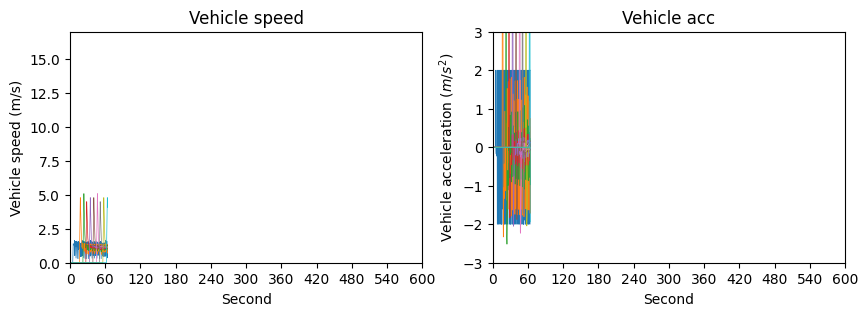

In [ ]:
# data analysis
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(10, 3), sharex=True, sharey=False)

for vid in range(1, 11):
      attacked_speed = [data['speed'] for data in attacked_data[vid]]
      attacked_acc = [data['acc'] for data in attacked_data[vid]]

      axs[0].plot(attacked_speed, lw=0.5)
      axs[1].plot(attacked_acc, lw=0.5)

axs[0].set_ylabel(r"Vehicle speed (m/s)")
axs[1].set_ylabel(r"Vehicle acceleration ($m/s^2$)")

axs[0].set_xticks(np.arange(0, 6001, 600))

axs[0].set_xticklabels(np.arange(0, 601, 60))

axs[0].set_xlabel("Second")
axs[1].set_xlabel("Second")

axs[0].set_title("Vehicle speed")
axs[1].set_title("Vehicle acc")

axs[0].set_xlim([0, 6000])
axs[0].set_ylim([0, 17])
axs[1].set_xlim([0, 6000])
axs[1].set_ylim([-3, 3])